In [1]:
import sys
sys.path.insert(0, 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\frxas.py')

import numpy as np
import h5py
import matplotlib.pyplot as plt
import lmfit
from lmfit import Parameters, minimize, report_fit

from frxas import hdf5_io
from frxas import models
from frxas import visualization

%reload_ext autoreload
%autoreload 2

In [20]:
def chi_pattern(x, ld, tg, kappa, gamma, aoo, po2, po2_ref, f):
    r"""Summarize the function in one line.

    Function for dimensionless vacancy concentrations assuming ideal behavior
    and overpotential control.

    Parameters
    ----------
    x : list or np.ndarray
        Array or list of arrays of length values.
    ld : float
        :math:`l_{\delta}` : Characteristic length scale of vacancy profile,
        often called the "utilization length".
    tg : float
        :math:`t_G`  : Characteristic time scale of vacancy profile. Reflects
        time scale of switching from kinetic limitations (low frequency) to
        co-limitation by kinetics and diffusion (moderate to high frequency).
    ao : float
        :math:`A_o` : Thermodynamic factor.
    kappa : float
        Bleh bleah
    gamma : float
        Bleh bleah
    f : float
        Applied linear frequency in units of Hz.

    Returns
    -------
    np.ndarray
        Evaluated function for given length array and parameters.
    """
    k = kappa
    g = gamma

    ao = models.calc_ao(aoo, po2, po2_ref)

    chi = -1 / (ao + ao * g * np.sqrt(2 * 10**k * (1 + 1j * tg * 2 * np.pi * f))) \
    * np.exp(-x / ld * np.sqrt(1 + 1j * tg * 2 * np.pi * f))

    return chi

In [3]:
f1 = hdf5_io.get_all_datasets('July18_frXAS_v2', start_indices = [[4, 2, 2], [4, 6, 0], [1, 2]])
hdf5_io.close_frxas_file('July18_frXAS_v2')

In [4]:
x, data, frequencies = hdf5_io.unpack_data(f1, kind='data_adj')

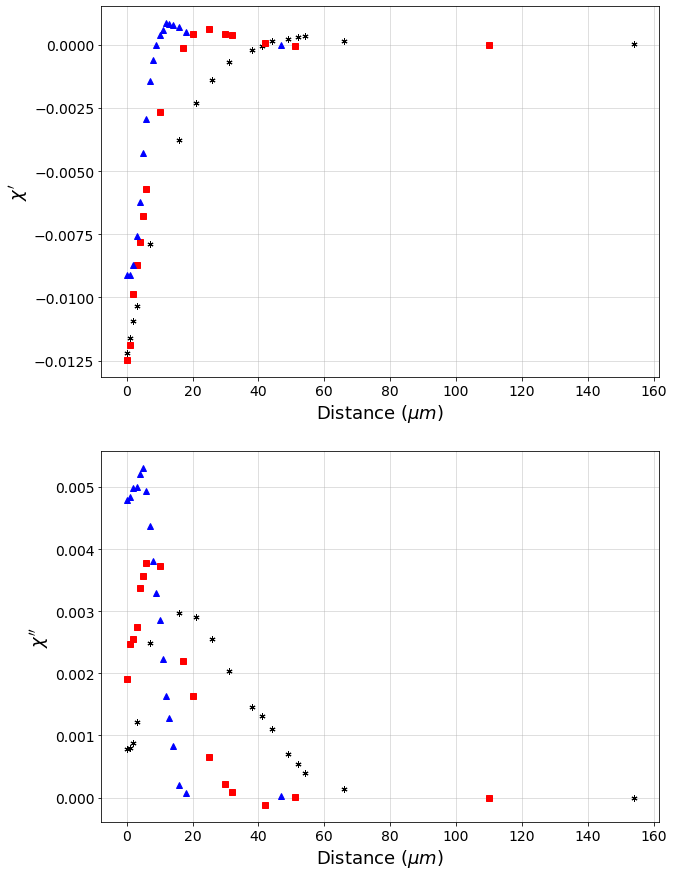

In [6]:
fig, axes = plt.subplots(nrows=2, figsize=(10,15))

visualization.plot_chi(axes, x[:3], data[:3])
# axes = visualization.plot_chi(axes, x[3:6], data[3:6])
# axes = visualization.plot_chi(axes, x[6:], data[6:])
# axes[1].set_xlim((420, 460))
plt.show()

In [21]:
fit_params = Parameters()

for iy, y in enumerate(data):
    fit_params.add('ld_%i' % (iy+1), value=10, min=0.0, max=200)
    fit_params.add('tg_%i' % (iy+1), value=.1, min=0.01, max=100.0)
    fit_params.add('kappa_%i' % (iy+1), value=-3, min=-8, max=1)
    fit_params.add('gamma_%i' % (iy+1), value=1, min=0, max=10)
    fit_params.add('aoo_%i' % (iy+1), value=1.5, min=1, max=5)
    fit_params.add('po2_%i' % (iy+1), value=0.01, vary=False)
    fit_params.add('po2_ref_%i' % (iy+1), value=1, vary=False)
    fit_params.add('f_%i' % (iy+1), value=frequencies[iy], vary=False)
        
for iy in np.arange(3,6):
    fit_params.add('po2_%i' % (iy+1), value=0.1, vary=False)
    fit_params['aoo_%i' % (iy+1)].expr = 'aoo_1'
for iy in np.arange(6,8):
    fit_params.add('po2_%i' % (iy+1), value=1, vary=False)
    fit_params['aoo_%i' % (iy+1)].expr = 'aoo_1'

In [22]:
for iy in np.arange(2, 4):
    fit_params['ld_%i' % iy].expr = 'ld_1'
    fit_params['tg_%i' % iy].expr = 'tg_1'
    fit_params['kappa_%i' % iy].expr = 'kappa_1'
    fit_params['gamma_%i' % iy].expr = 'gamma_1'
    fit_params['aoo_%i' % iy].expr = 'aoo_1'
    fit_params['po2_%i' % iy].expr = 'po2_1'
    fit_params['po2_ref_%i' % iy].expr = 'po2_ref_1'

for iy in np.arange(5, 7):
    fit_params['ld_%i' % iy].expr = 'ld_4'
    fit_params['tg_%i' % iy].expr = 'tg_4'
    fit_params['kappa_%i' % iy].expr = 'kappa_4'
    fit_params['gamma_%i' % iy].expr = 'gamma_4'
    fit_params['aoo_%i' % iy].expr = 'aoo_1'
    fit_params['po2_%i' % iy].expr = 'po2_4'
    fit_params['po2_ref_%i' % iy].expr = 'po2_ref_4'

for iy in np.arange(8, 9):
    fit_params['ld_%i' % iy].expr = 'ld_7'
    fit_params['tg_%i' % iy].expr = 'tg_7'
    fit_params['kappa_%i' % iy].expr = 'kappa_7'
    fit_params['gamma_%i' % iy].expr = 'gamma_7'
    fit_params['aoo_%i' % iy].expr = 'aoo_1'
    fit_params['po2_%i' % iy].expr = 'po2_7'
    fit_params['po2_ref_%i' % iy].expr = 'po2_ref_7'

In [23]:
out = minimize(models.objective_fun, fit_params, args=(x, data, chi_pattern))
report_fit(out.params)

[[Variables]]
    ld_1:       9.24037413 +/- 0.59843752 (6.48%) (init = 10)
    tg_1:       0.07359205 +/- 0.01492234 (20.28%) (init = 0.1)
    kappa_1:   -0.37156312 +/- 69358.0618 (18666562.63%) (init = -3)
    gamma_1:    9.95116071 +/- 779724.441 (7835512.49%) (init = 1)
    aoo_1:      4.99999818 +/- 53.5578379 (1071.16%) (init = 1.5)
    po2_1:      0.01 (fixed)
    po2_ref_1:  1 (fixed)
    f_1:        0.25 (fixed)
    ld_2:       9.24037413 +/- 0.59057791 (6.39%) == 'ld_1'
    tg_2:       0.07359205 +/- 0.07352626 (99.91%) == 'tg_1'
    kappa_2:   -0.37156312 +/- 69358.0618 (18666562.63%) == 'kappa_1'
    gamma_2:    9.95116071 +/- 779724.442 (7835512.50%) == 'gamma_1'
    aoo_2:      4.99999818 +/- 53.5585333 (1071.17%) == 'aoo_1'
    po2_2:      0.01000000 +/- 0.00000000 (0.00%) == 'po2_1'
    po2_ref_2:  1.00000000 +/- 0.00000000 (0.00%) == 'po2_ref_1'
    f_2:        1 (fixed)
    ld_3:       9.24037413 +/- 0.59057791 (6.39%) == 'ld_1'
    tg_3:       0.07359205 +/- 0.07352

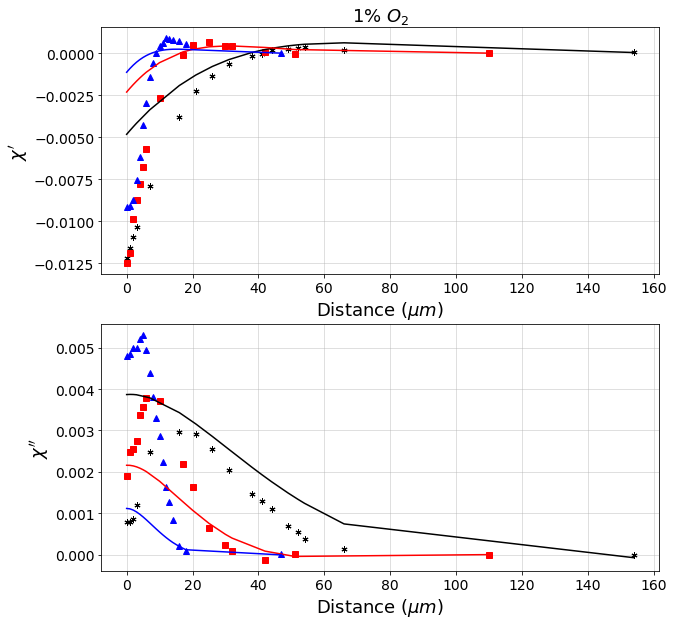

In [17]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(0,3):
    visualization.plot_chi(axes, x[iy], data[iy], ls='')
for iy in np.arange(0,3):
    visualization.plot_chi(axes, x[iy], models.dataset_fun(out.params, iy, x[iy], models.chi_pattern), marker='')
    
axes[0].set_title('1% $O_2$', fontsize=18)
plt.show()

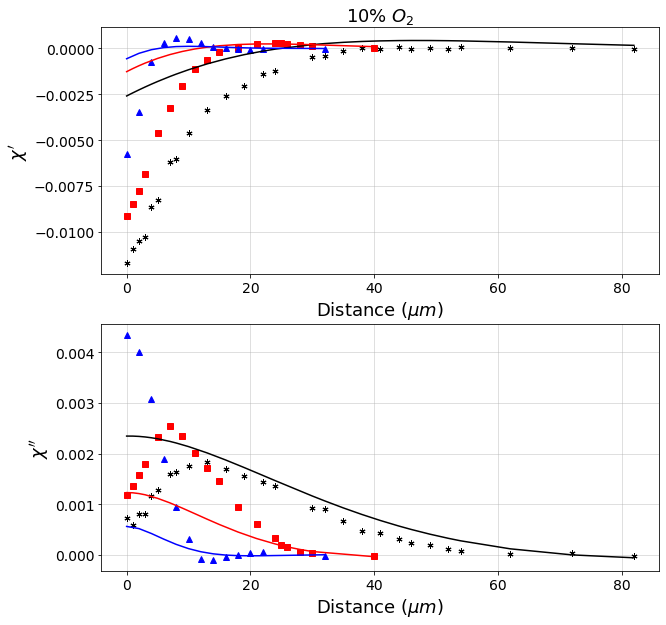

In [18]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(3,6):
    visualization.plot_chi(axes, x[iy], data[iy], ls='')
for iy in np.arange(3,6):
    visualization.plot_chi(axes, x[iy], models.dataset_fun(out.params, iy, x[iy], models.chi_pattern), marker='')
    
axes[0].set_title('10% $O_2$', fontsize=18)
plt.show()

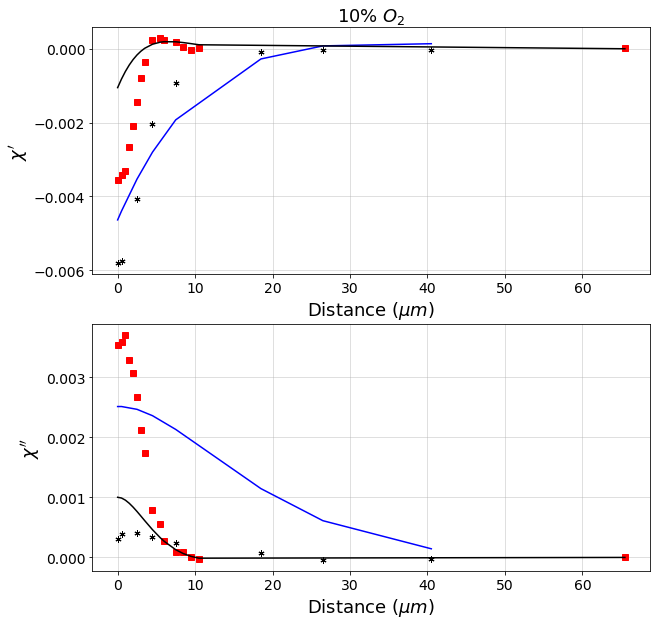

In [19]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(6,8):
    visualization.plot_chi(axes, x[iy], data[iy], ls='')
for iy in np.arange(6,8):
    visualization.plot_chi(axes, x[iy], models.dataset_fun(out.params, iy, x[iy], models.chi_pattern), marker='')
    
axes[0].set_title('10% $O_2$', fontsize=18)
plt.show()

Data clearly not fitting to the patterned model. Seemingly occurs because the real data isn't scaled to 1 (max values for real components are ~0.002)

In [28]:
y = models.chi_pattern(xx, 20, 1, 1e-3, .5, 1.5, .01, 1, 5)
np.array([xx,y])

array([[ 0.00000000e+00+0.00000000e+00j,  2.00000000e+00+0.00000000e+00j,
         4.00000000e+00+0.00000000e+00j,  6.00000000e+00+0.00000000e+00j,
         8.00000000e+00+0.00000000e+00j,  1.00000000e+01+0.00000000e+00j,
         1.20000000e+01+0.00000000e+00j,  1.40000000e+01+0.00000000e+00j,
         1.60000000e+01+0.00000000e+00j,  1.80000000e+01+0.00000000e+00j,
         2.00000000e+01+0.00000000e+00j,  2.20000000e+01+0.00000000e+00j,
         2.40000000e+01+0.00000000e+00j,  2.60000000e+01+0.00000000e+00j,
         2.80000000e+01+0.00000000e+00j,  3.00000000e+01+0.00000000e+00j,
         3.20000000e+01+0.00000000e+00j,  3.40000000e+01+0.00000000e+00j,
         3.60000000e+01+0.00000000e+00j,  3.80000000e+01+0.00000000e+00j,
         4.00000000e+01+0.00000000e+00j,  4.20000000e+01+0.00000000e+00j,
         4.40000000e+01+0.00000000e+00j,  4.60000000e+01+0.00000000e+00j,
         4.80000000e+01+0.00000000e+00j,  5.00000000e+01+0.00000000e+00j,
         5.20000000e+01+0.00000000e+00

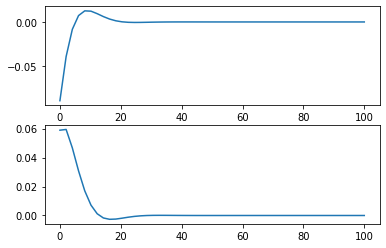

In [17]:
fig, ax = plt.subplots(nrows=2)

ax[0].plot(xx, y.real)
ax[1].plot(xx,y.imag)